In [1]:
import numpy as np
import io_subs
import importlib
importlib.reload(io_subs)
import sim_tb
importlib.reload(sim_tb)
import pyresample
from pyresample import kd_tree, geometry
from pyresample.kd_tree import resample_nearest, resample_gauss, resample_custom
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pyresample import image, geometry
import lkTables

lookupT=lkTables.scattTables()

import xarray as xr
wf = lambda r: 1 - r/20000.0
import glob

f2BCMB=glob.glob('/Volumes/T7 Shield/SUBSETS/Subsets/2B-CS-CONUS*')
f2BCMB=sorted(f2BCMB)
f1CGMI=glob.glob('/Volumes/T7 Shield/SUBSETS/Subsets/1C-*CONUS*')
f1CGMI=sorted(f1CGMI)
print(len(f2BCMB),len(f1CGMI))

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): dim_0(289), dim_1(8)
    variables(dimensions): float32 kextR(dim_0, dim_1), float32 salbR(dim_0, dim_1), float32 asymR(dim_0, dim_1), float32 kextS(dim_0, dim_1), float32 salbS(dim_0, dim_1), float32 asymS(dim_0, dim_1), float32 kextG(dim_0, dim_1), float32 salbG(dim_0, dim_1), float32 asymG(dim_0, dim_1)
    groups: 
658 734


In [2]:
importlib.reload(sim_tb)
for f in f2BCMB[310:]:
    orbit_cmb=f.split('/')[-1].split('.')[-3]
    for f1 in f1CGMI:
        orbit_gmi=f1.split('/')[-1].split('.')[-3]
        if orbit_cmb==orbit_gmi:
            break
    if orbit_cmb==orbit_gmi:
        print(orbit_cmb,orbit_gmi)
        # Read the CMB and GMI data
        qv,press,envNodes,airTemp,skTemp,binNodes,pwc,sfcEmiss,dm,cldw,sfcBin,zCorrected,pType,lon,lat=io_subs.readCMB(f)
        pType=(pType/1e7).astype(int)
        lat_s1,lon_s1,tb_s1=io_subs.read1CGMI(f1)

# Define the input and output grids
        input_def = geometry.SwathDefinition(lons=lon_s1[:,:], lats=lat_s1[:,:])
        output_def = geometry.SwathDefinition(lons=lon, lats=lat)
# Resample the tb_s1 data to the CMB grid using gaussian resampling

        tb_s1_resampled = resample_custom(input_def, tb_s1[:,:,:], output_def, radius_of_influence=30000, neighbours=10, 
        weight_funcs=[wf for k in range(9)], fill_value=None)

        hFreqs=[1,1,2,2,3,4,4,5,5,6,6,7,7]

        tb_sim2,iwp2,rwp2,wvp=sim_tb.sim_tb(sfcEmiss,skTemp,envNodes,binNodes,pType,pwc,dm,airTemp,press,qv,sfcBin,lookupT)
        nt=pwc.shape[0]

        tbX=xr.DataArray(tb_sim2,coords={'scan':np.arange(nt),'ray':np.arange(49),'freq':hFreqs},dims=['scan','ray','freq'])
        tb_resampledX=xr.DataArray(tb_s1_resampled,coords={'scan':np.arange(nt),'ray':np.arange(49),'freq2':hFreqs[:9]},dims=['scan','ray','freq2'])
        iwpX=xr.DataArray(iwp2,coords={'scan':np.arange(nt),'ray':np.arange(49)},dims=['scan','ray'])
        rwpX=xr.DataArray(rwp2,coords={'scan':np.arange(nt),'ray':np.arange(49)},dims=['scan','ray'])
        sfcEmissX=xr.DataArray(sfcEmiss,coords={'scan':np.arange(nt),'ray':np.arange(49),'freq':hFreqs},dims=['scan','ray','freq'])
        skTempX=xr.DataArray(skTemp,coords={'scan':np.arange(nt),'ray':np.arange(49)},dims=['scan','ray'])
        sfcBinX=xr.DataArray(sfcBin[:,:,0],coords={'scan':np.arange(nt),'ray':np.arange(49)},dims=['scan','ray'])
        pTypeX=xr.DataArray(pType,coords={'scan':np.arange(nt),'ray':np.arange(49)},dims=['scan','ray'])
        wvpX=xr.DataArray(wvp,coords={'scan':np.arange(nt),'ray':np.arange(49)},dims=['scan','ray'])
        lonX=xr.DataArray(lon,coords={'scan':np.arange(nt),'ray':np.arange(49)},dims=['scan','ray'])
        latX=xr.DataArray(lat,coords={'scan':np.arange(nt),'ray':np.arange(49)},dims=['scan','ray'])
        ds=xr.Dataset({'tb':tbX,'tb_resampled':tb_resampledX,'iwp':iwpX,'rwp':rwpX,'sfcEmiss':sfcEmissX,'skTemp':skTempX,'sfcBin':sfcBinX,'pType':pTypeX,'wvp':wvpX,'lon':lonX,'lat':latX})
        complevel=5
        encoding = {var: {'zlib': True, 'complevel': complevel} for var in ds.data_vars}
        ds.to_netcdf('output/CMB_GMI_Tbs_CONUS_'+orbit_cmb+'.nc',encoding=encoding)
        #break

030042 030042


/Users/mgrecu/miniconda3/lib/python3.9/site-packages/pyresample/kd_tree.py:261: UserWarning: Possible more than 10 neighbours within 30000 m for some data points
  get_neighbour_info(source_geo_def,
100%|██████████| 423/423 [00:06<00:00, 61.81it/s]


1814


1814it [00:02, 753.94it/s]


(423, 49, 78, 8)
(423, 49, 78, 8)


100%|██████████| 423/423 [00:07<00:00, 58.26it/s]


030043 030043


/Users/mgrecu/miniconda3/lib/python3.9/site-packages/pyresample/kd_tree.py:261: UserWarning: Possible more than 10 neighbours within 30000 m for some data points
  get_neighbour_info(source_geo_def,
100%|██████████| 741/741 [00:11<00:00, 62.96it/s]


3091


3091it [00:04, 749.76it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 58.72it/s]


030044 030044


100%|██████████| 729/729 [00:11<00:00, 62.69it/s]


1277


1277it [00:01, 839.70it/s]


(729, 49, 78, 8)
(729, 49, 78, 8)


100%|██████████| 729/729 [00:11<00:00, 61.36it/s]


030052 030052


100%|██████████| 628/628 [00:10<00:00, 62.76it/s]


7709


7709it [00:12, 637.26it/s]


(628, 49, 78, 8)
(628, 49, 78, 8)


100%|██████████| 628/628 [00:10<00:00, 58.61it/s]


030053 030053


100%|██████████| 743/743 [00:11<00:00, 62.78it/s]


0


0it [00:00, ?it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 59.20it/s]


030054 030054


100%|██████████| 685/685 [00:10<00:00, 62.78it/s]


443


443it [00:00, 1007.98it/s]


(685, 49, 78, 8)
(685, 49, 78, 8)


100%|██████████| 685/685 [00:11<00:00, 59.39it/s]


030057 030057


100%|██████████| 142/142 [00:02<00:00, 63.05it/s]


280


280it [00:00, 1805.92it/s]


(142, 49, 78, 8)
(142, 49, 78, 8)


100%|██████████| 142/142 [00:02<00:00, 57.81it/s]


030058 030058


100%|██████████| 742/742 [00:11<00:00, 62.78it/s]


4416


4416it [00:05, 759.53it/s]


(742, 49, 78, 8)
(742, 49, 78, 8)


100%|██████████| 742/742 [00:12<00:00, 58.67it/s]


030059 030059


100%|██████████| 741/741 [00:11<00:00, 62.71it/s]


5005


5005it [00:05, 887.64it/s] 


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 61.10it/s]


030060 030060


100%|██████████| 349/349 [00:05<00:00, 62.73it/s]


0


0it [00:00, ?it/s]


(349, 49, 78, 8)
(349, 49, 78, 8)


100%|██████████| 349/349 [00:05<00:00, 58.18it/s]


030067 030067


100%|██████████| 349/349 [00:05<00:00, 62.65it/s]


397


397it [00:00, 1379.98it/s]


(349, 49, 78, 8)
(349, 49, 78, 8)


100%|██████████| 349/349 [00:06<00:00, 58.11it/s]


030068 030068


100%|██████████| 742/742 [00:11<00:00, 62.83it/s]


3419


3419it [00:03, 893.50it/s] 


(742, 49, 78, 8)
(742, 49, 78, 8)


100%|██████████| 742/742 [00:12<00:00, 58.31it/s]


030069 030069


100%|██████████| 743/743 [00:11<00:00, 62.85it/s]


947


947it [00:01, 734.90it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 60.16it/s]


030070 030070


100%|██████████| 141/141 [00:02<00:00, 63.18it/s]


4


4it [00:00, 2440.68it/s]


(141, 49, 78, 8)
(141, 49, 78, 8)


100%|██████████| 141/141 [00:02<00:00, 58.72it/s]


030073 030073


100%|██████████| 686/686 [00:10<00:00, 62.88it/s]


4608


4608it [00:05, 834.48it/s] 


(686, 49, 78, 8)
(686, 49, 78, 8)


100%|██████████| 686/686 [00:11<00:00, 58.14it/s]


030074 030074


100%|██████████| 741/741 [00:11<00:00, 62.57it/s]


2802


2802it [00:03, 803.66it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 58.85it/s]


030075 030075


100%|██████████| 628/628 [00:10<00:00, 62.74it/s]


179


179it [00:00, 856.39it/s]


(628, 49, 78, 8)
(628, 49, 78, 8)


100%|██████████| 628/628 [00:10<00:00, 59.22it/s]


030083 030083


100%|██████████| 729/729 [00:11<00:00, 62.86it/s]


2580


2580it [00:03, 846.66it/s]


(729, 49, 78, 8)
(729, 49, 78, 8)


100%|██████████| 729/729 [00:12<00:00, 58.50it/s]


030084 030084


100%|██████████| 742/742 [00:11<00:00, 62.79it/s]


1061


1061it [00:01, 644.64it/s]


(742, 49, 78, 8)
(742, 49, 78, 8)


100%|██████████| 742/742 [00:12<00:00, 59.88it/s]


030085 030085


100%|██████████| 423/423 [00:06<00:00, 62.76it/s]


23


23it [00:00, 997.04it/s]


(423, 49, 78, 8)
(423, 49, 78, 8)


100%|██████████| 423/423 [00:07<00:00, 59.99it/s]


030088 030088


100%|██████████| 328/328 [00:05<00:00, 62.83it/s]


3089


3089it [00:03, 782.44it/s]


(328, 49, 78, 8)
(328, 49, 78, 8)


100%|██████████| 328/328 [00:05<00:00, 58.57it/s]


030089 030089


100%|██████████| 741/741 [00:11<00:00, 62.79it/s]


9933


9933it [00:13, 727.58it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 58.49it/s]


030090 030090


100%|██████████| 741/741 [00:11<00:00, 62.87it/s]


1400


1400it [00:01, 859.97it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 61.46it/s]


030091 030091


100%|██████████| 86/86 [00:01<00:00, 62.37it/s]


0


0it [00:00, ?it/s]


(86, 49, 78, 8)
(86, 49, 78, 8)


100%|██████████| 86/86 [00:01<00:00, 57.93it/s]


030098 030098


100%|██████████| 553/553 [00:08<00:00, 62.88it/s]


1556


1556it [00:01, 946.84it/s]


(553, 49, 78, 8)
(553, 49, 78, 8)


100%|██████████| 553/553 [00:09<00:00, 57.78it/s]


030099 030099


100%|██████████| 742/742 [00:11<00:00, 62.63it/s]


7898


7898it [00:11, 666.68it/s] 


(742, 49, 78, 8)
(742, 49, 78, 8)


100%|██████████| 742/742 [00:12<00:00, 58.93it/s]


030100 030100


100%|██████████| 736/736 [00:11<00:00, 62.80it/s]


735


735it [00:00, 922.61it/s]


(736, 49, 78, 8)
(736, 49, 78, 8)


100%|██████████| 736/736 [00:12<00:00, 59.79it/s]


030103 030103


100%|██████████| 73/73 [00:01<00:00, 60.95it/s]


34


34it [00:00, 1242.04it/s]


(73, 49, 78, 8)
(73, 49, 78, 8)


100%|██████████| 73/73 [00:01<00:00, 58.05it/s]


030104 030104


100%|██████████| 742/742 [00:11<00:00, 62.64it/s]


2694


2694it [00:02, 929.99it/s] 


(742, 49, 78, 8)
(742, 49, 78, 8)


100%|██████████| 742/742 [00:12<00:00, 58.42it/s]


030105 030105


100%|██████████| 742/742 [00:11<00:00, 62.81it/s]


4484


4484it [00:05, 780.84it/s] 


(742, 49, 78, 8)
(742, 49, 78, 8)


100%|██████████| 742/742 [00:12<00:00, 59.63it/s]


030106 030106


100%|██████████| 445/445 [00:07<00:00, 62.66it/s]


1


1it [00:00, 2505.56it/s]


(445, 49, 78, 8)
(445, 49, 78, 8)


100%|██████████| 445/445 [00:07<00:00, 58.12it/s]


030113 030113


100%|██████████| 242/242 [00:03<00:00, 62.83it/s]


285


285it [00:00, 2218.81it/s]


(242, 49, 78, 8)
(242, 49, 78, 8)


100%|██████████| 242/242 [00:04<00:00, 57.83it/s]


030114 030114


100%|██████████| 742/742 [00:11<00:00, 62.73it/s]


1558


1558it [00:01, 858.62it/s] 


(742, 49, 78, 8)
(742, 49, 78, 8)


100%|██████████| 742/742 [00:12<00:00, 58.38it/s]


030115 030115


100%|██████████| 743/743 [00:11<00:00, 62.95it/s]


1822


1822it [00:02, 875.95it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 60.01it/s]


030116 030116


100%|██████████| 217/217 [00:03<00:00, 62.52it/s]


41


41it [00:00, 896.69it/s]


(217, 49, 78, 8)
(217, 49, 78, 8)


100%|██████████| 217/217 [00:03<00:00, 58.81it/s]


030119 030119


100%|██████████| 564/564 [00:08<00:00, 62.75it/s]


452


452it [00:00, 890.92it/s]


(564, 49, 78, 8)
(564, 49, 78, 8)


100%|██████████| 564/564 [00:09<00:00, 58.11it/s]


030120 030120


100%|██████████| 741/741 [00:11<00:00, 62.89it/s]


3577


3577it [00:05, 671.71it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 58.83it/s]


030121 030121


100%|██████████| 696/696 [00:11<00:00, 62.31it/s]


1632


1632it [00:02, 814.86it/s]


(696, 49, 78, 8)
(696, 49, 78, 8)


100%|██████████| 696/696 [00:11<00:00, 59.33it/s]


030129 030129


100%|██████████| 704/704 [00:11<00:00, 62.59it/s]


1845


1845it [00:02, 881.51it/s]


(704, 49, 78, 8)
(704, 49, 78, 8)


100%|██████████| 704/704 [00:12<00:00, 58.21it/s]


030130 030130


100%|██████████| 743/743 [00:11<00:00, 62.73it/s]


2793


2793it [00:03, 758.56it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 59.32it/s]


030131 030131


100%|██████████| 530/530 [00:08<00:00, 62.87it/s]


84


84it [00:00, 992.35it/s]


(530, 49, 78, 8)
(530, 49, 78, 8)


100%|██████████| 530/530 [00:08<00:00, 59.55it/s]


030134 030134


100%|██████████| 240/240 [00:03<00:00, 62.47it/s]


18


18it [00:00, 3984.04it/s]


(240, 49, 78, 8)
(240, 49, 78, 8)


100%|██████████| 240/240 [00:04<00:00, 58.50it/s]


030135 030135


100%|██████████| 741/741 [00:11<00:00, 62.73it/s]


4064


4064it [00:05, 765.18it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 57.70it/s]


030136 030136


100%|██████████| 741/741 [00:11<00:00, 62.77it/s]


5245


5245it [00:06, 832.94it/s] 


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 61.29it/s]


030137 030137


100%|██████████| 210/210 [00:03<00:00, 62.87it/s]


0


0it [00:00, ?it/s]


(210, 49, 78, 8)
(210, 49, 78, 8)


100%|██████████| 210/210 [00:03<00:00, 58.02it/s]


030144 030144


100%|██████████| 469/469 [00:07<00:00, 62.69it/s]


3342


3342it [00:04, 714.78it/s]


(469, 49, 78, 8)
(469, 49, 78, 8)


100%|██████████| 469/469 [00:08<00:00, 58.13it/s]


030145 030145


100%|██████████| 743/743 [00:11<00:00, 62.71it/s]


2704


2704it [00:03, 784.25it/s] 


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 58.55it/s]


030146 030146


100%|██████████| 743/743 [00:11<00:00, 62.79it/s]


303


303it [00:00, 867.41it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 59.76it/s]


030147 030147


100%|██████████| 54/54 [00:00<00:00, 62.55it/s]


23


23it [00:00, 1288.38it/s]


(54, 49, 78, 8)
(54, 49, 78, 8)


100%|██████████| 54/54 [00:00<00:00, 57.79it/s]


030149 030149


100%|██████████| 10/10 [00:00<00:00, 61.98it/s]


13


13it [00:00, 1347.85it/s]


(10, 49, 78, 8)
(10, 49, 78, 8)


100%|██████████| 10/10 [00:00<00:00, 56.14it/s]


030150 030150


100%|██████████| 741/741 [00:11<00:00, 62.71it/s]


4232


4232it [00:05, 790.72it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 58.28it/s]


030151 030151


100%|██████████| 741/741 [00:11<00:00, 62.76it/s]


1682


1682it [00:02, 732.97it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 59.27it/s]


030152 030152


100%|██████████| 531/531 [00:08<00:00, 62.54it/s]


3


3it [00:00, 3393.45it/s]


(531, 49, 78, 8)
(531, 49, 78, 8)


100%|██████████| 531/531 [00:09<00:00, 58.38it/s]


030159 030159


100%|██████████| 121/121 [00:01<00:00, 62.61it/s]


28


28it [00:00, 3420.83it/s]


(121, 49, 78, 8)
(121, 49, 78, 8)


100%|██████████| 121/121 [00:02<00:00, 57.56it/s]


030160 030160


100%|██████████| 742/742 [00:11<00:00, 62.76it/s]


4248


4248it [00:05, 774.82it/s]


(742, 49, 78, 8)
(742, 49, 78, 8)


100%|██████████| 742/742 [00:12<00:00, 58.78it/s]


030161 030161


100%|██████████| 742/742 [00:11<00:00, 62.64it/s]


1900


1900it [00:02, 741.23it/s]


(742, 49, 78, 8)
(742, 49, 78, 8)


100%|██████████| 742/742 [00:12<00:00, 60.26it/s]


030162 030162


100%|██████████| 302/302 [00:04<00:00, 62.78it/s]


846


846it [00:00, 2065.58it/s]


(302, 49, 78, 8)
(302, 49, 78, 8)


100%|██████████| 302/302 [00:05<00:00, 59.63it/s]


030165 030165


100%|██████████| 453/453 [00:07<00:00, 62.76it/s]


4790


4790it [00:07, 647.03it/s]


(453, 49, 78, 8)
(453, 49, 78, 8)


100%|██████████| 453/453 [00:07<00:00, 58.54it/s]


030166 030166


100%|██████████| 742/742 [00:11<00:00, 62.86it/s]


5077


5077it [00:07, 703.75it/s]


(742, 49, 78, 8)
(742, 49, 78, 8)


100%|██████████| 742/742 [00:12<00:00, 58.38it/s]


030167 030167


100%|██████████| 722/722 [00:11<00:00, 62.88it/s]


455


455it [00:00, 892.30it/s] 


(722, 49, 78, 8)
(722, 49, 78, 8)


100%|██████████| 722/722 [00:11<00:00, 60.74it/s]


030175 030175


100%|██████████| 647/647 [00:10<00:00, 62.63it/s]


3970


3970it [00:05, 719.74it/s]


(647, 49, 78, 8)
(647, 49, 78, 8)


100%|██████████| 647/647 [00:11<00:00, 58.26it/s]


030176 030176


100%|██████████| 742/742 [00:11<00:00, 62.60it/s]


3515


3515it [00:04, 746.10it/s] 


(742, 49, 78, 8)
(742, 49, 78, 8)


100%|██████████| 742/742 [00:12<00:00, 59.46it/s]


030177 030177


100%|██████████| 650/650 [00:10<00:00, 62.27it/s]


839


839it [00:00, 1324.84it/s]


(650, 49, 78, 8)
(650, 49, 78, 8)


100%|██████████| 650/650 [00:10<00:00, 60.26it/s]


030180 030180


100%|██████████| 161/161 [00:02<00:00, 62.42it/s]


1977


1977it [00:03, 561.35it/s]


(161, 49, 78, 8)
(161, 49, 78, 8)


100%|██████████| 161/161 [00:02<00:00, 58.47it/s]


030181 030181


100%|██████████| 741/741 [00:11<00:00, 62.77it/s]


21


21it [00:00, 1520.75it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 58.42it/s]


030182 030182


100%|██████████| 741/741 [00:11<00:00, 62.72it/s]


2028


2028it [00:01, 1775.21it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 61.10it/s]


030183 030183


100%|██████████| 321/321 [00:05<00:00, 62.79it/s]


0


0it [00:00, ?it/s]


(321, 49, 78, 8)
(321, 49, 78, 8)


100%|██████████| 321/321 [00:05<00:00, 58.27it/s]


030190 030190


100%|██████████| 376/376 [00:05<00:00, 62.94it/s]


852


852it [00:00, 1569.56it/s]


(376, 49, 78, 8)
(376, 49, 78, 8)


100%|██████████| 376/376 [00:06<00:00, 58.20it/s]


030191 030191


100%|██████████| 742/742 [00:11<00:00, 62.64it/s]


2007


2007it [00:03, 661.31it/s] 


(742, 49, 78, 8)
(742, 49, 78, 8)


100%|██████████| 742/742 [00:12<00:00, 58.41it/s]


030192 030192


100%|██████████| 742/742 [00:11<00:00, 62.69it/s]


464


464it [00:00, 1729.21it/s]


(742, 49, 78, 8)
(742, 49, 78, 8)


100%|██████████| 742/742 [00:12<00:00, 59.37it/s]


030193 030193


100%|██████████| 121/121 [00:01<00:00, 62.98it/s]


3


3it [00:00, 2043.34it/s]


(121, 49, 78, 8)
(121, 49, 78, 8)


100%|██████████| 121/121 [00:02<00:00, 58.60it/s]


030196 030196


100%|██████████| 718/718 [00:11<00:00, 62.82it/s]


910


910it [00:00, 949.58it/s] 


(718, 49, 78, 8)
(718, 49, 78, 8)


100%|██████████| 718/718 [00:12<00:00, 58.62it/s]


030197 030197


100%|██████████| 741/741 [00:11<00:00, 62.75it/s]


3620


3620it [00:04, 842.03it/s] 


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 59.02it/s]


030198 030198


100%|██████████| 610/610 [00:09<00:00, 62.74it/s]


2


2it [00:00, 1901.32it/s]


(610, 49, 78, 8)
(610, 49, 78, 8)


100%|██████████| 610/610 [00:10<00:00, 58.93it/s]


030206 030206


100%|██████████| 736/736 [00:11<00:00, 62.67it/s]


254


254it [00:00, 2617.91it/s]


(736, 49, 78, 8)
(736, 49, 78, 8)


100%|██████████| 736/736 [00:12<00:00, 58.60it/s]


030207 030207


100%|██████████| 742/742 [00:11<00:00, 62.69it/s]


1440


1440it [00:01, 1129.44it/s]


(742, 49, 78, 8)
(742, 49, 78, 8)


100%|██████████| 742/742 [00:12<00:00, 59.67it/s]


030208 030208


100%|██████████| 395/395 [00:06<00:00, 62.76it/s]


308


308it [00:00, 1623.62it/s]


(395, 49, 78, 8)
(395, 49, 78, 8)


100%|██████████| 395/395 [00:06<00:00, 59.33it/s]


030211 030211


100%|██████████| 352/352 [00:05<00:00, 62.80it/s]


0


0it [00:00, ?it/s]


(352, 49, 78, 8)
(352, 49, 78, 8)


100%|██████████| 352/352 [00:05<00:00, 58.67it/s]


030212 030212


100%|██████████| 741/741 [00:11<00:00, 62.69it/s]


3551


3551it [00:04, 765.37it/s] 


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 58.41it/s]


030213 030213


100%|██████████| 741/741 [00:11<00:00, 62.91it/s]


305


305it [00:00, 816.26it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 61.00it/s]


030214 030214


100%|██████████| 51/51 [00:00<00:00, 59.68it/s]


0


0it [00:00, ?it/s]


(51, 49, 78, 8)
(51, 49, 78, 8)


100%|██████████| 51/51 [00:00<00:00, 56.58it/s]


030221 030221


100%|██████████| 574/574 [00:09<00:00, 62.78it/s]


255


255it [00:00, 996.27it/s]


(574, 49, 78, 8)
(574, 49, 78, 8)


100%|██████████| 574/574 [00:09<00:00, 57.88it/s]


030222 030222


100%|██████████| 743/743 [00:11<00:00, 62.87it/s]


3056


3056it [00:03, 904.91it/s] 


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 58.94it/s]


030223 030223


100%|██████████| 729/729 [00:11<00:00, 62.62it/s]


412


412it [00:00, 1104.35it/s]


(729, 49, 78, 8)
(729, 49, 78, 8)


100%|██████████| 729/729 [00:12<00:00, 59.32it/s]


030226 030226


100%|██████████| 91/91 [00:01<00:00, 62.52it/s]


2


2it [00:00, 1407.72it/s]


(91, 49, 78, 8)
(91, 49, 78, 8)


100%|██████████| 91/91 [00:01<00:00, 58.59it/s]


030227 030227


100%|██████████| 742/742 [00:11<00:00, 62.82it/s]


2157


2157it [00:02, 834.92it/s] 


(742, 49, 78, 8)
(742, 49, 78, 8)


100%|██████████| 742/742 [00:12<00:00, 58.33it/s]


030228 030228


100%|██████████| 742/742 [00:11<00:00, 62.92it/s]


3075


3075it [00:04, 724.40it/s] 


(742, 49, 78, 8)
(742, 49, 78, 8)


100%|██████████| 742/742 [00:12<00:00, 60.10it/s]


030229 030229


100%|██████████| 421/421 [00:06<00:00, 63.00it/s]


0


0it [00:00, ?it/s]


(421, 49, 78, 8)
(421, 49, 78, 8)


100%|██████████| 421/421 [00:07<00:00, 58.16it/s]


030236 030236


100%|██████████| 271/271 [00:04<00:00, 62.83it/s]


401


401it [00:00, 1491.71it/s]


(271, 49, 78, 8)
(271, 49, 78, 8)


100%|██████████| 271/271 [00:04<00:00, 58.28it/s]


030237 030237


100%|██████████| 742/742 [00:11<00:00, 62.81it/s]


2694


2694it [00:04, 589.71it/s]


(742, 49, 78, 8)
(742, 49, 78, 8)


100%|██████████| 742/742 [00:12<00:00, 58.32it/s]


030238 030238


100%|██████████| 742/742 [00:11<00:00, 62.85it/s]


864


864it [00:01, 783.16it/s] 


(742, 49, 78, 8)
(742, 49, 78, 8)


100%|██████████| 742/742 [00:12<00:00, 60.21it/s]


030239 030239


100%|██████████| 196/196 [00:03<00:00, 62.50it/s]


108


108it [00:00, 1085.43it/s]


(196, 49, 78, 8)
(196, 49, 78, 8)


100%|██████████| 196/196 [00:03<00:00, 58.71it/s]


030242 030242


100%|██████████| 595/595 [00:09<00:00, 62.71it/s]


2904


2904it [00:03, 760.40it/s] 


(595, 49, 78, 8)
(595, 49, 78, 8)


100%|██████████| 595/595 [00:10<00:00, 58.09it/s]


030243 030243


100%|██████████| 744/744 [00:11<00:00, 62.76it/s]


354


354it [00:00, 996.55it/s] 


(744, 49, 78, 8)
(744, 49, 78, 8)


100%|██████████| 744/744 [00:12<00:00, 58.60it/s]


030244 030244


100%|██████████| 679/679 [00:10<00:00, 62.60it/s]


202


202it [00:00, 980.85it/s]


(679, 49, 78, 8)
(679, 49, 78, 8)


100%|██████████| 679/679 [00:11<00:00, 59.55it/s]


030252 030252


100%|██████████| 710/710 [00:11<00:00, 62.73it/s]


1219


1219it [00:01, 1043.98it/s]


(710, 49, 78, 8)
(710, 49, 78, 8)


100%|██████████| 710/710 [00:12<00:00, 58.34it/s]


030253 030253


100%|██████████| 741/741 [00:11<00:00, 62.63it/s]


1950


1950it [00:02, 734.95it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 59.47it/s]


030254 030254


100%|██████████| 500/500 [00:07<00:00, 62.64it/s]


68


68it [00:00, 784.65it/s]


(500, 49, 78, 8)
(500, 49, 78, 8)


100%|██████████| 500/500 [00:08<00:00, 58.96it/s]


030257 030257


100%|██████████| 262/262 [00:04<00:00, 62.91it/s]


1561


1561it [00:01, 923.67it/s]


(262, 49, 78, 8)
(262, 49, 78, 8)


100%|██████████| 262/262 [00:04<00:00, 58.35it/s]


030258 030258


100%|██████████| 743/743 [00:11<00:00, 61.99it/s]


424


424it [00:00, 892.45it/s] 


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 58.74it/s]


030259 030259


100%|██████████| 743/743 [00:11<00:00, 62.84it/s]


830


830it [00:00, 1104.29it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 61.66it/s]


030260 030260


100%|██████████| 177/177 [00:02<00:00, 62.84it/s]


0


0it [00:00, ?it/s]


(177, 49, 78, 8)
(177, 49, 78, 8)


100%|██████████| 177/177 [00:03<00:00, 57.88it/s]


030267 030267


100%|██████████| 496/496 [00:07<00:00, 62.73it/s]


1520


1520it [00:01, 1110.96it/s]


(496, 49, 78, 8)
(496, 49, 78, 8)


100%|██████████| 496/496 [00:08<00:00, 55.90it/s]


030268 030268


100%|██████████| 741/741 [00:11<00:00, 62.79it/s]


840


840it [00:01, 804.71it/s] 


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 58.77it/s]


030269 030269


100%|██████████| 741/741 [00:11<00:00, 62.88it/s]


619


619it [00:00, 690.93it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 60.17it/s]


030270 030270


100%|██████████| 34/34 [00:00<00:00, 62.92it/s]


68


68it [00:00, 958.10it/s]


(34, 49, 78, 8)
(34, 49, 78, 8)


100%|██████████| 34/34 [00:00<00:00, 57.38it/s]


030272 030272


100%|██████████| 28/28 [00:00<00:00, 63.03it/s]


0


0it [00:00, ?it/s]


(28, 49, 78, 8)
(28, 49, 78, 8)


100%|██████████| 28/28 [00:00<00:00, 57.36it/s]


030273 030273


100%|██████████| 743/743 [00:11<00:00, 62.75it/s]


502


502it [00:00, 1142.99it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 58.37it/s]


030274 030274


100%|██████████| 743/743 [00:11<00:00, 62.83it/s]


1900


1900it [00:02, 751.24it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 59.38it/s]


030275 030275


100%|██████████| 505/505 [00:08<00:00, 62.53it/s]


68


68it [00:00, 810.52it/s]


(505, 49, 78, 8)
(505, 49, 78, 8)


100%|██████████| 505/505 [00:08<00:00, 58.36it/s]


030282 030282


100%|██████████| 165/165 [00:02<00:00, 62.65it/s]


500


500it [00:00, 1378.15it/s]


(165, 49, 78, 8)
(165, 49, 78, 8)


100%|██████████| 165/165 [00:02<00:00, 58.22it/s]


030283 030283


100%|██████████| 741/741 [00:11<00:00, 62.67it/s]


754


754it [00:01, 710.02it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 58.26it/s]


030284 030284


100%|██████████| 741/741 [00:11<00:00, 62.42it/s]


980


980it [00:01, 730.92it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 60.39it/s]


030285 030285


100%|██████████| 270/270 [00:04<00:00, 62.74it/s]


448


448it [00:00, 1401.45it/s]


(270, 49, 78, 8)
(270, 49, 78, 8)


100%|██████████| 270/270 [00:04<00:00, 59.22it/s]


030288 030288


100%|██████████| 491/491 [00:07<00:00, 62.76it/s]


98


98it [00:00, 1860.11it/s]


(491, 49, 78, 8)
(491, 49, 78, 8)


100%|██████████| 491/491 [00:08<00:00, 58.47it/s]


030289 030289


100%|██████████| 743/743 [00:11<00:00, 62.64it/s]


3958


3958it [00:05, 755.56it/s] 


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 58.69it/s]


030290 030290


100%|██████████| 714/714 [00:11<00:00, 62.84it/s]


574


574it [00:00, 1184.93it/s]


(714, 49, 78, 8)
(714, 49, 78, 8)


100%|██████████| 714/714 [00:11<00:00, 60.25it/s]


030298 030298


100%|██████████| 675/675 [00:10<00:00, 62.83it/s]


2097


2097it [00:02, 756.65it/s]


(675, 49, 78, 8)
(675, 49, 78, 8)


100%|██████████| 675/675 [00:11<00:00, 58.49it/s]


030299 030299


100%|██████████| 741/741 [00:11<00:00, 62.84it/s]


24


24it [00:00, 804.03it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 59.55it/s]


030300 030300


100%|██████████| 601/601 [00:09<00:00, 62.74it/s]


1807


1807it [00:01, 1068.29it/s]


(601, 49, 78, 8)
(601, 49, 78, 8)


100%|██████████| 601/601 [00:10<00:00, 60.04it/s]


030303 030303


100%|██████████| 192/192 [00:03<00:00, 62.71it/s]


1839


1839it [00:02, 726.68it/s]


(192, 49, 78, 8)
(192, 49, 78, 8)


100%|██████████| 192/192 [00:03<00:00, 58.89it/s]


030304 030304


100%|██████████| 743/743 [00:11<00:00, 62.69it/s]


2489


2489it [00:03, 703.67it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 58.62it/s]


030305 030305


100%|██████████| 743/743 [00:11<00:00, 62.66it/s]


124


124it [00:00, 789.70it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 61.17it/s]


030306 030306


100%|██████████| 276/276 [00:04<00:00, 62.70it/s]


382


382it [00:00, 995.05it/s] 


(276, 49, 78, 8)
(276, 49, 78, 8)


100%|██████████| 276/276 [00:04<00:00, 58.44it/s]


030313 030313


100%|██████████| 419/419 [00:06<00:00, 62.57it/s]


848


848it [00:00, 943.19it/s] 


(419, 49, 78, 8)
(419, 49, 78, 8)


100%|██████████| 419/419 [00:07<00:00, 58.42it/s]


030314 030314


100%|██████████| 741/741 [00:11<00:00, 62.77it/s]


216


216it [00:00, 1018.03it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 58.64it/s]


030315 030315


100%|██████████| 741/741 [00:11<00:00, 62.85it/s]


4128


4128it [00:04, 940.32it/s] 


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 60.26it/s]


030316 030316


100%|██████████| 91/91 [00:01<00:00, 62.72it/s]


2


2it [00:00, 1639.36it/s]


(91, 49, 78, 8)
(91, 49, 78, 8)


100%|██████████| 91/91 [00:01<00:00, 58.14it/s]


030319 030319


100%|██████████| 730/730 [00:11<00:00, 62.90it/s]


360


360it [00:00, 1279.80it/s]


(730, 49, 78, 8)
(730, 49, 78, 8)


100%|██████████| 730/730 [00:12<00:00, 58.53it/s]


030320 030320


100%|██████████| 743/743 [00:11<00:00, 62.94it/s]


2251


2251it [00:03, 724.78it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 59.45it/s]


030321 030321


100%|██████████| 574/574 [00:09<00:00, 62.85it/s]


18


18it [00:00, 4159.87it/s]


(574, 49, 78, 8)
(574, 49, 78, 8)


100%|██████████| 574/574 [00:09<00:00, 58.42it/s]


030328 030328


100%|██████████| 54/54 [00:00<00:00, 61.86it/s]


17


17it [00:00, 2049.12it/s]


(54, 49, 78, 8)
(54, 49, 78, 8)


100%|██████████| 54/54 [00:00<00:00, 56.51it/s]


030329 030329


100%|██████████| 741/741 [00:11<00:00, 62.83it/s]


1485


1485it [00:01, 956.99it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 58.79it/s]


030330 030330


100%|██████████| 741/741 [00:11<00:00, 62.83it/s]


5171


5171it [00:08, 603.16it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 60.12it/s]


030331 030331


100%|██████████| 348/348 [00:05<00:00, 62.81it/s]


61


61it [00:00, 1055.46it/s]


(348, 49, 78, 8)
(348, 49, 78, 8)


100%|██████████| 348/348 [00:05<00:00, 59.17it/s]


030334 030334


100%|██████████| 401/401 [00:06<00:00, 62.75it/s]


269


269it [00:00, 1509.28it/s]


(401, 49, 78, 8)
(401, 49, 78, 8)


100%|██████████| 401/401 [00:06<00:00, 58.53it/s]


030335 030335


100%|██████████| 743/743 [00:11<00:00, 62.82it/s]


1248


1248it [00:01, 866.11it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 58.63it/s]


030336 030336


100%|██████████| 736/736 [00:11<00:00, 62.82it/s]


827


827it [00:00, 873.00it/s] 


(736, 49, 78, 8)
(736, 49, 78, 8)


100%|██████████| 736/736 [00:11<00:00, 61.51it/s]


030344 030344


100%|██████████| 614/614 [00:09<00:00, 62.63it/s]


28


28it [00:00, 1084.22it/s]


(614, 49, 78, 8)
(614, 49, 78, 8)


100%|██████████| 614/614 [00:10<00:00, 58.37it/s]


030345 030345


100%|██████████| 741/741 [00:11<00:00, 62.92it/s]


1393


1393it [00:01, 743.47it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 59.48it/s]


030346 030346


100%|██████████| 710/710 [00:11<00:00, 62.79it/s]


10


10it [00:00, 1337.09it/s]


(710, 49, 78, 8)
(710, 49, 78, 8)


100%|██████████| 710/710 [00:11<00:00, 60.20it/s]


030349 030349


100%|██████████| 128/128 [00:02<00:00, 62.57it/s]


2168


2168it [00:03, 684.25it/s]


(128, 49, 78, 8)
(128, 49, 78, 8)


100%|██████████| 128/128 [00:02<00:00, 58.46it/s]


030350 030350


100%|██████████| 743/743 [00:11<00:00, 62.78it/s]


2084


2084it [00:02, 793.88it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 58.67it/s]


030351 030351


100%|██████████| 743/743 [00:11<00:00, 62.83it/s]


4791


4791it [00:06, 733.36it/s] 


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 59.98it/s]


030352 030352


100%|██████████| 367/367 [00:05<00:00, 62.80it/s]


0


0it [00:00, ?it/s]


(367, 49, 78, 8)
(367, 49, 78, 8)


100%|██████████| 367/367 [00:06<00:00, 58.18it/s]


030359 030359


100%|██████████| 334/334 [00:05<00:00, 62.68it/s]


152


152it [00:00, 2290.22it/s]


(334, 49, 78, 8)
(334, 49, 78, 8)


100%|██████████| 334/334 [00:05<00:00, 58.01it/s]


030360 030360


100%|██████████| 741/741 [00:11<00:00, 62.73it/s]


1500


1500it [00:02, 615.94it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 58.55it/s]


030361 030361


100%|██████████| 741/741 [00:11<00:00, 62.74it/s]


829


829it [00:01, 816.97it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 60.35it/s]


030362 030362


100%|██████████| 151/151 [00:02<00:00, 62.62it/s]


8


8it [00:00, 2447.98it/s]


(151, 49, 78, 8)
(151, 49, 78, 8)


100%|██████████| 151/151 [00:02<00:00, 58.63it/s]


030365 030365


100%|██████████| 669/669 [00:10<00:00, 62.79it/s]


848


848it [00:00, 1088.45it/s]


(669, 49, 78, 8)
(669, 49, 78, 8)


100%|██████████| 669/669 [00:11<00:00, 58.61it/s]


030366 030366


100%|██████████| 743/743 [00:11<00:00, 62.75it/s]


2123


2123it [00:03, 683.82it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 59.21it/s]


030367 030367


100%|██████████| 638/638 [00:10<00:00, 61.77it/s]


6


6it [00:00, 2640.97it/s]


(638, 49, 78, 8)
(638, 49, 78, 8)


100%|██████████| 638/638 [00:10<00:00, 59.57it/s]


030375 030375


100%|██████████| 726/726 [00:11<00:00, 62.49it/s]


962


962it [00:01, 715.02it/s]


(726, 49, 78, 8)
(726, 49, 78, 8)


100%|██████████| 726/726 [00:12<00:00, 58.85it/s]


030376 030376


100%|██████████| 741/741 [00:11<00:00, 62.74it/s]


5253


5253it [00:07, 663.39it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 60.08it/s]


030377 030377


100%|██████████| 433/433 [00:06<00:00, 62.72it/s]


336


336it [00:00, 910.15it/s] 


(433, 49, 78, 8)
(433, 49, 78, 8)


100%|██████████| 433/433 [00:07<00:00, 59.31it/s]


030380 030380


100%|██████████| 319/319 [00:05<00:00, 62.94it/s]


1


1it [00:00, 2232.20it/s]


(319, 49, 78, 8)
(319, 49, 78, 8)


100%|██████████| 319/319 [00:05<00:00, 58.61it/s]


030381 030381


100%|██████████| 743/743 [00:11<00:00, 62.68it/s]


1075


1075it [00:01, 855.35it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 58.57it/s]


030382 030382


100%|██████████| 743/743 [00:11<00:00, 62.63it/s]


343


343it [00:00, 1075.84it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 60.46it/s]


030383 030383


100%|██████████| 97/97 [00:01<00:00, 62.72it/s]


34


34it [00:00, 1558.57it/s]


(97, 49, 78, 8)
(97, 49, 78, 8)


100%|██████████| 97/97 [00:01<00:00, 57.16it/s]


030390 030390


100%|██████████| 549/549 [00:08<00:00, 62.83it/s]


734


734it [00:00, 1025.14it/s]


(549, 49, 78, 8)
(549, 49, 78, 8)


100%|██████████| 549/549 [00:09<00:00, 58.36it/s]


030391 030391


100%|██████████| 741/741 [00:11<00:00, 62.95it/s]


3273


3273it [00:04, 717.29it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 59.23it/s]


030392 030392


100%|██████████| 736/736 [00:11<00:00, 62.81it/s]


887


887it [00:01, 878.58it/s] 


(736, 49, 78, 8)
(736, 49, 78, 8)


100%|██████████| 736/736 [00:12<00:00, 60.02it/s]


030395 030395


100%|██████████| 69/69 [00:01<00:00, 62.84it/s]


255


255it [00:00, 634.75it/s]


(69, 49, 78, 8)
(69, 49, 78, 8)


100%|██████████| 69/69 [00:01<00:00, 58.23it/s]


030396 030396


100%|██████████| 743/743 [00:11<00:00, 62.78it/s]


892


892it [00:00, 1058.82it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 58.32it/s]


030397 030397


100%|██████████| 743/743 [00:11<00:00, 62.76it/s]


1951


1951it [00:02, 704.55it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 59.61it/s]


030398 030398


100%|██████████| 450/450 [00:07<00:00, 62.62it/s]


0


0it [00:00, ?it/s]


(450, 49, 78, 8)
(450, 49, 78, 8)


100%|██████████| 450/450 [00:07<00:00, 58.08it/s]


030405 030405


100%|██████████| 239/239 [00:03<00:00, 62.71it/s]


179


179it [00:00, 2213.19it/s]


(239, 49, 78, 8)
(239, 49, 78, 8)


100%|██████████| 239/239 [00:04<00:00, 58.28it/s]


030406 030406


100%|██████████| 741/741 [00:11<00:00, 62.86it/s]


1669


1669it [00:02, 742.65it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 58.72it/s]


030407 030407


100%|██████████| 741/741 [00:11<00:00, 62.89it/s]


1254


1254it [00:01, 1033.15it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 60.27it/s]


030408 030408


100%|██████████| 217/217 [00:03<00:00, 62.84it/s]


1578


1578it [00:01, 927.84it/s]


(217, 49, 78, 8)
(217, 49, 78, 8)


100%|██████████| 217/217 [00:03<00:00, 59.23it/s]


030411 030411


100%|██████████| 564/564 [00:08<00:00, 62.82it/s]


1017


1017it [00:01, 749.79it/s]


(564, 49, 78, 8)
(564, 49, 78, 8)


100%|██████████| 564/564 [00:09<00:00, 58.53it/s]


030412 030412


100%|██████████| 744/744 [00:11<00:00, 62.90it/s]


1026


1026it [00:01, 751.67it/s]


(744, 49, 78, 8)
(744, 49, 78, 8)


100%|██████████| 744/744 [00:12<00:00, 59.00it/s]


030413 030413


100%|██████████| 696/696 [00:11<00:00, 62.83it/s]


138


138it [00:00, 1195.80it/s]


(696, 49, 78, 8)
(696, 49, 78, 8)


100%|██████████| 696/696 [00:11<00:00, 59.62it/s]


030421 030421


100%|██████████| 705/705 [00:11<00:00, 62.82it/s]


3299


3299it [00:04, 677.37it/s]


(705, 49, 78, 8)
(705, 49, 78, 8)


100%|██████████| 705/705 [00:12<00:00, 58.61it/s]


030422 030422


100%|██████████| 741/741 [00:11<00:00, 62.75it/s]


4400


4400it [00:06, 688.49it/s] 


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 59.62it/s]


030423 030423


100%|██████████| 527/527 [00:08<00:00, 62.85it/s]


601


601it [00:00, 812.73it/s]


(527, 49, 78, 8)
(527, 49, 78, 8)


100%|██████████| 527/527 [00:08<00:00, 59.90it/s]


030426 030426


100%|██████████| 243/243 [00:03<00:00, 62.89it/s]


92


92it [00:00, 872.96it/s]


(243, 49, 78, 8)
(243, 49, 78, 8)


100%|██████████| 243/243 [00:04<00:00, 58.51it/s]


030427 030427


100%|██████████| 743/743 [00:11<00:00, 62.80it/s]


1625


1625it [00:01, 830.80it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 58.44it/s]


030428 030428


100%|██████████| 744/744 [00:11<00:00, 62.84it/s]


1141


1141it [00:00, 1173.16it/s]


(744, 49, 78, 8)
(744, 49, 78, 8)


100%|██████████| 744/744 [00:12<00:00, 59.66it/s]


030429 030429


100%|██████████| 205/205 [00:03<00:00, 62.54it/s]


0


0it [00:00, ?it/s]


(205, 49, 78, 8)
(205, 49, 78, 8)


100%|██████████| 205/205 [00:03<00:00, 57.50it/s]


030436 030436


100%|██████████| 476/476 [00:07<00:00, 62.76it/s]


1768


1768it [00:02, 722.55it/s]


(476, 49, 78, 8)
(476, 49, 78, 8)


100%|██████████| 476/476 [00:08<00:00, 58.29it/s]


030437 030437


100%|██████████| 741/741 [00:11<00:00, 62.69it/s]


9


9it [00:00, 1048.72it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 58.02it/s]


030438 030438


100%|██████████| 741/741 [00:11<00:00, 62.81it/s]


4209


4209it [00:06, 616.22it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 60.07it/s]


030439 030439


100%|██████████| 49/49 [00:00<00:00, 62.64it/s]


0


0it [00:00, ?it/s]


(49, 49, 78, 8)
(49, 49, 78, 8)


100%|██████████| 49/49 [00:00<00:00, 57.27it/s]


030441 030441


100%|██████████| 15/15 [00:00<00:00, 62.08it/s]


0


0it [00:00, ?it/s]


(15, 49, 78, 8)
(15, 49, 78, 8)


100%|██████████| 15/15 [00:00<00:00, 54.32it/s]


030442 030442


100%|██████████| 743/743 [00:11<00:00, 62.77it/s]


4200


4200it [00:06, 697.67it/s] 


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 58.34it/s]


030443 030443


100%|██████████| 743/743 [00:11<00:00, 62.77it/s]


1496


1496it [00:01, 776.53it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 59.29it/s]


030444 030444


100%|██████████| 525/525 [00:08<00:00, 62.52it/s]


176


176it [00:00, 1067.62it/s]


(525, 49, 78, 8)
(525, 49, 78, 8)


100%|██████████| 525/525 [00:08<00:00, 58.48it/s]


030451 030451


100%|██████████| 135/135 [00:02<00:00, 62.71it/s]


247


247it [00:00, 2198.29it/s]


(135, 49, 78, 8)
(135, 49, 78, 8)


100%|██████████| 135/135 [00:02<00:00, 57.91it/s]


030452 030452


100%|██████████| 741/741 [00:11<00:00, 62.90it/s]


1177


1177it [00:01, 801.23it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 58.98it/s]


030453 030453


100%|██████████| 740/740 [00:11<00:00, 62.95it/s]


5370


5370it [00:08, 666.63it/s] 


(740, 49, 78, 8)
(740, 49, 78, 8)


100%|██████████| 740/740 [00:12<00:00, 59.72it/s]


030454 030454


100%|██████████| 291/291 [00:04<00:00, 62.67it/s]


1317


1317it [00:01, 923.59it/s]


(291, 49, 78, 8)
(291, 49, 78, 8)


100%|██████████| 291/291 [00:04<00:00, 58.91it/s]


030457 030457


100%|██████████| 466/466 [00:07<00:00, 62.67it/s]


1440


1440it [00:02, 651.35it/s]


(466, 49, 78, 8)
(466, 49, 78, 8)


100%|██████████| 466/466 [00:07<00:00, 58.49it/s]


030458 030458


100%|██████████| 743/743 [00:11<00:00, 62.80it/s]


9769


9769it [00:14, 659.64it/s] 


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 58.82it/s]


030459 030459


100%|██████████| 720/720 [00:11<00:00, 62.51it/s]


79


79it [00:00, 1360.33it/s]


(720, 49, 78, 8)
(720, 49, 78, 8)


100%|██████████| 720/720 [00:11<00:00, 60.44it/s]


030467 030467


100%|██████████| 659/659 [00:10<00:00, 63.01it/s]


1687


1687it [00:02, 782.79it/s]


(659, 49, 78, 8)
(659, 49, 78, 8)


100%|██████████| 659/659 [00:11<00:00, 58.10it/s]


030468 030468


100%|██████████| 741/741 [00:11<00:00, 62.78it/s]


3144


3144it [00:03, 805.02it/s] 


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 59.55it/s]


030469 030469


100%|██████████| 630/630 [00:10<00:00, 62.84it/s]


64


64it [00:00, 1415.43it/s]


(630, 49, 78, 8)
(630, 49, 78, 8)


100%|██████████| 630/630 [00:10<00:00, 59.93it/s]


030472 030472


100%|██████████| 174/174 [00:02<00:00, 62.95it/s]


1


1it [00:00, 2493.64it/s]


(174, 49, 78, 8)
(174, 49, 78, 8)


100%|██████████| 174/174 [00:02<00:00, 58.14it/s]


030473 030473


100%|██████████| 743/743 [00:12<00:00, 61.70it/s]


3842


3842it [00:05, 765.26it/s] 


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 58.72it/s]


030474 030474


100%|██████████| 744/744 [00:11<00:00, 62.76it/s]


786


786it [00:00, 929.81it/s]


(744, 49, 78, 8)
(744, 49, 78, 8)


100%|██████████| 744/744 [00:12<00:00, 60.92it/s]


030475 030475


100%|██████████| 303/303 [00:04<00:00, 62.97it/s]


1


1it [00:00, 2525.17it/s]


(303, 49, 78, 8)
(303, 49, 78, 8)


100%|██████████| 303/303 [00:05<00:00, 58.14it/s]


030482 030482


100%|██████████| 396/396 [00:06<00:00, 62.81it/s]


652


652it [00:00, 1265.32it/s]


(396, 49, 78, 8)
(396, 49, 78, 8)


100%|██████████| 396/396 [00:06<00:00, 58.20it/s]


030483 030483


100%|██████████| 741/741 [00:11<00:00, 62.71it/s]


3384


3384it [00:04, 698.61it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 58.81it/s]


030484 030484


100%|██████████| 740/740 [00:11<00:00, 62.69it/s]


10


10it [00:00, 1387.37it/s]


(740, 49, 78, 8)
(740, 49, 78, 8)


100%|██████████| 740/740 [00:12<00:00, 59.73it/s]


030485 030485


100%|██████████| 107/107 [00:01<00:00, 62.71it/s]


67


67it [00:00, 1001.64it/s]


(107, 49, 78, 8)
(107, 49, 78, 8)


100%|██████████| 107/107 [00:01<00:00, 58.93it/s]


030488 030488


100%|██████████| 723/723 [00:11<00:00, 62.83it/s]


2034


2034it [00:02, 960.69it/s] 


(723, 49, 78, 8)
(723, 49, 78, 8)


100%|██████████| 723/723 [00:12<00:00, 58.64it/s]


030489 030489


100%|██████████| 744/744 [00:11<00:00, 62.80it/s]


4022


4022it [00:07, 559.66it/s]


(744, 49, 78, 8)
(744, 49, 78, 8)


100%|██████████| 744/744 [00:12<00:00, 59.17it/s]


030490 030490


100%|██████████| 593/593 [00:09<00:00, 62.93it/s]


66


66it [00:00, 2115.52it/s]


(593, 49, 78, 8)
(593, 49, 78, 8)


100%|██████████| 593/593 [00:10<00:00, 58.91it/s]


030497 030497


100%|██████████| 21/21 [00:00<00:00, 62.35it/s]


34


34it [00:00, 1438.61it/s]


(21, 49, 78, 8)
(21, 49, 78, 8)


100%|██████████| 21/21 [00:00<00:00, 55.37it/s]


030498 030498


100%|██████████| 741/741 [00:11<00:00, 62.81it/s]


7449


7449it [00:11, 675.48it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 58.41it/s]


030499 030499


100%|██████████| 740/740 [00:11<00:00, 62.56it/s]


5373


5373it [00:07, 712.29it/s] 


(740, 49, 78, 8)
(740, 49, 78, 8)


100%|██████████| 740/740 [00:12<00:00, 59.62it/s]


030500 030500


100%|██████████| 371/371 [00:05<00:00, 62.80it/s]


48


48it [00:00, 1430.50it/s]


(371, 49, 78, 8)
(371, 49, 78, 8)


100%|██████████| 371/371 [00:06<00:00, 59.46it/s]


030503 030503


100%|██████████| 377/377 [00:05<00:00, 62.87it/s]


2600


2600it [00:03, 653.08it/s] 


(377, 49, 78, 8)
(377, 49, 78, 8)


100%|██████████| 377/377 [00:06<00:00, 58.51it/s]


030504 030504


100%|██████████| 744/744 [00:11<00:00, 62.84it/s]


1151


1151it [00:01, 862.00it/s]


(744, 49, 78, 8)
(744, 49, 78, 8)


100%|██████████| 744/744 [00:12<00:00, 58.56it/s]


030505 030505


100%|██████████| 743/743 [00:11<00:00, 62.84it/s]


28


28it [00:00, 1349.39it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 61.12it/s]


030506 030506


100%|██████████| 14/14 [00:00<00:00, 62.63it/s]


0


0it [00:00, ?it/s]


(14, 49, 78, 8)
(14, 49, 78, 8)


100%|██████████| 14/14 [00:00<00:00, 54.74it/s]


030513 030513


100%|██████████| 597/597 [00:09<00:00, 62.88it/s]


767


767it [00:00, 1175.67it/s]


(597, 49, 78, 8)
(597, 49, 78, 8)


100%|██████████| 597/597 [00:10<00:00, 58.43it/s]


030514 030514


100%|██████████| 741/741 [00:11<00:00, 62.81it/s]


1173


1173it [00:01, 815.01it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 59.30it/s]


030515 030515


100%|██████████| 722/722 [00:11<00:00, 62.86it/s]


1071


1071it [00:01, 986.76it/s]


(722, 49, 78, 8)
(722, 49, 78, 8)


100%|██████████| 722/722 [00:11<00:00, 60.43it/s]


030518 030518


100%|██████████| 111/111 [00:01<00:00, 62.71it/s]


348


348it [00:00, 977.51it/s]


(111, 49, 78, 8)
(111, 49, 78, 8)


100%|██████████| 111/111 [00:01<00:00, 58.13it/s]


030519 030519


100%|██████████| 744/744 [00:11<00:00, 62.85it/s]


1326


1326it [00:01, 679.14it/s]


(744, 49, 78, 8)
(744, 49, 78, 8)


100%|██████████| 744/744 [00:12<00:00, 58.80it/s]


030520 030520


100%|██████████| 743/743 [00:11<00:00, 62.87it/s]


235


235it [00:00, 801.42it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 60.77it/s]


030521 030521


100%|██████████| 392/392 [00:06<00:00, 62.93it/s]


0


0it [00:00, ?it/s]


(392, 49, 78, 8)
(392, 49, 78, 8)


100%|██████████| 392/392 [00:06<00:00, 58.04it/s]


030528 030528


100%|██████████| 307/307 [00:04<00:00, 62.66it/s]


332


332it [00:00, 1605.97it/s]


(307, 49, 78, 8)
(307, 49, 78, 8)


100%|██████████| 307/307 [00:05<00:00, 58.24it/s]


030529 030529


100%|██████████| 741/741 [00:11<00:00, 62.85it/s]


8637


8637it [00:12, 693.41it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 58.39it/s]


030530 030530


100%|██████████| 741/741 [00:11<00:00, 62.87it/s]


2980


2980it [00:03, 828.83it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 60.37it/s]


030531 030531


100%|██████████| 170/170 [00:02<00:00, 62.94it/s]


51


51it [00:00, 836.60it/s]


(170, 49, 78, 8)
(170, 49, 78, 8)


100%|██████████| 170/170 [00:02<00:00, 58.75it/s]


030534 030534


100%|██████████| 638/638 [00:10<00:00, 62.91it/s]


1095


1095it [00:01, 750.36it/s]


(638, 49, 78, 8)
(638, 49, 78, 8)


100%|██████████| 638/638 [00:10<00:00, 58.49it/s]


030535 030535


100%|██████████| 744/744 [00:11<00:00, 62.81it/s]


7484


7484it [00:10, 723.67it/s] 


(744, 49, 78, 8)
(744, 49, 78, 8)


100%|██████████| 744/744 [00:12<00:00, 59.04it/s]


030536 030536


100%|██████████| 655/655 [00:10<00:00, 62.86it/s]


129


129it [00:00, 841.09it/s]


(655, 49, 78, 8)
(655, 49, 78, 8)


100%|██████████| 655/655 [00:11<00:00, 59.42it/s]


030544 030544


100%|██████████| 719/719 [00:11<00:00, 62.69it/s]


1004


1004it [00:01, 915.25it/s]


(719, 49, 78, 8)
(719, 49, 78, 8)


100%|██████████| 719/719 [00:12<00:00, 58.54it/s]


030545 030545


100%|██████████| 741/741 [00:11<00:00, 62.81it/s]


2341


2341it [00:03, 658.78it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 59.98it/s]


030546 030546


100%|██████████| 459/459 [00:07<00:00, 62.78it/s]


217


217it [00:00, 956.76it/s] 


(459, 49, 78, 8)
(459, 49, 78, 8)


100%|██████████| 459/459 [00:07<00:00, 60.21it/s]


030549 030549


100%|██████████| 296/296 [00:04<00:00, 62.92it/s]


1


1it [00:00, 2551.28it/s]


(296, 49, 78, 8)
(296, 49, 78, 8)


100%|██████████| 296/296 [00:05<00:00, 58.36it/s]


030550 030550


100%|██████████| 744/744 [00:11<00:00, 62.81it/s]


2037


2037it [00:02, 835.45it/s]


(744, 49, 78, 8)
(744, 49, 78, 8)


100%|██████████| 744/744 [00:12<00:00, 58.73it/s]


030551 030551


100%|██████████| 743/743 [00:11<00:00, 62.86it/s]


688


688it [00:00, 978.78it/s] 


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 61.64it/s]


030552 030552


100%|██████████| 129/129 [00:02<00:00, 62.42it/s]


0


0it [00:00, ?it/s]


(129, 49, 78, 8)
(129, 49, 78, 8)


100%|██████████| 129/129 [00:02<00:00, 57.49it/s]


030559 030559


100%|██████████| 528/528 [00:08<00:00, 62.79it/s]


596


596it [00:00, 1131.22it/s]


(528, 49, 78, 8)
(528, 49, 78, 8)


100%|██████████| 528/528 [00:09<00:00, 58.24it/s]


030560 030560


100%|██████████| 741/741 [00:11<00:00, 62.77it/s]


1826


1826it [00:02, 811.20it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 58.88it/s]


030561 030561


100%|██████████| 740/740 [00:11<00:00, 62.94it/s]


856


856it [00:00, 861.21it/s]


(740, 49, 78, 8)
(740, 49, 78, 8)


100%|██████████| 740/740 [00:12<00:00, 60.09it/s]


030562 030562


100%|██████████| 11/11 [00:00<00:00, 59.35it/s]


1


1it [00:00, 945.09it/s]


(11, 49, 78, 8)
(11, 49, 78, 8)


100%|██████████| 11/11 [00:00<00:00, 56.74it/s]


030564 030564


100%|██████████| 53/53 [00:00<00:00, 62.84it/s]


1


1it [00:00, 2347.12it/s]


(53, 49, 78, 8)
(53, 49, 78, 8)


100%|██████████| 53/53 [00:00<00:00, 58.31it/s]


030565 030565


100%|██████████| 743/743 [00:11<00:00, 62.94it/s]


563


563it [00:00, 1109.01it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 58.60it/s]


030566 030566


100%|██████████| 744/744 [00:11<00:00, 62.73it/s]


1546


1546it [00:02, 739.91it/s]


(744, 49, 78, 8)
(744, 49, 78, 8)


100%|██████████| 744/744 [00:12<00:00, 59.67it/s]


030567 030567


100%|██████████| 472/472 [00:07<00:00, 62.83it/s]


1


1it [00:00, 555.17it/s]


(472, 49, 78, 8)
(472, 49, 78, 8)


100%|██████████| 472/472 [00:08<00:00, 58.01it/s]


030574 030574


100%|██████████| 210/210 [00:03<00:00, 62.94it/s]


218


218it [00:00, 1688.41it/s]


(210, 49, 78, 8)
(210, 49, 78, 8)


100%|██████████| 210/210 [00:03<00:00, 58.20it/s]


030575 030575


100%|██████████| 741/741 [00:11<00:00, 62.69it/s]


4550


4550it [00:06, 696.47it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 57.88it/s]


030576 030576


100%|██████████| 741/741 [00:11<00:00, 62.85it/s]


4225


4225it [00:05, 747.36it/s] 


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 60.19it/s]


030577 030577


100%|██████████| 239/239 [00:03<00:00, 62.74it/s]


157


157it [00:00, 959.92it/s] 


(239, 49, 78, 8)
(239, 49, 78, 8)


100%|██████████| 239/239 [00:04<00:00, 59.41it/s]


030580 030580


100%|██████████| 533/533 [00:08<00:00, 62.82it/s]


2069


2069it [00:02, 722.96it/s] 


(533, 49, 78, 8)
(533, 49, 78, 8)


100%|██████████| 533/533 [00:09<00:00, 58.36it/s]


030581 030581


100%|██████████| 743/743 [00:11<00:00, 62.87it/s]


4967


4967it [00:08, 568.89it/s] 


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 58.80it/s]


030582 030582


100%|██████████| 705/705 [00:11<00:00, 63.03it/s]


3721


3721it [00:04, 756.60it/s] 


(705, 49, 78, 8)
(705, 49, 78, 8)


100%|██████████| 705/705 [00:11<00:00, 59.22it/s]


030590 030590


100%|██████████| 698/698 [00:11<00:00, 62.78it/s]


5189


5189it [00:07, 668.00it/s] 


(698, 49, 78, 8)
(698, 49, 78, 8)


100%|██████████| 698/698 [00:11<00:00, 58.55it/s]


030591 030591


100%|██████████| 741/741 [00:11<00:00, 62.36it/s]


6263


6263it [00:09, 674.00it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 59.55it/s]


030592 030592


100%|██████████| 557/557 [00:08<00:00, 62.88it/s]


96


96it [00:00, 990.80it/s]


(557, 49, 78, 8)
(557, 49, 78, 8)


100%|██████████| 557/557 [00:09<00:00, 59.61it/s]


030595 030595


100%|██████████| 223/223 [00:03<00:00, 62.87it/s]


11


11it [00:00, 2562.47it/s]


(223, 49, 78, 8)
(223, 49, 78, 8)


100%|██████████| 223/223 [00:03<00:00, 58.46it/s]


030596 030596


100%|██████████| 744/744 [00:11<00:00, 62.60it/s]


4998


4998it [00:08, 622.25it/s] 


(744, 49, 78, 8)
(744, 49, 78, 8)


100%|██████████| 744/744 [00:12<00:00, 58.73it/s]


030597 030597


100%|██████████| 743/743 [00:11<00:00, 62.78it/s]


381


381it [00:00, 1291.18it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 61.60it/s]


030598 030598


100%|██████████| 235/235 [00:03<00:00, 62.92it/s]


0


0it [00:00, ?it/s]


(235, 49, 78, 8)
(235, 49, 78, 8)


100%|██████████| 235/235 [00:04<00:00, 58.06it/s]


030605 030605


100%|██████████| 452/452 [00:07<00:00, 62.50it/s]


1587


1587it [00:02, 709.28it/s]


(452, 49, 78, 8)
(452, 49, 78, 8)


100%|██████████| 452/452 [00:07<00:00, 57.97it/s]


030606 030606


100%|██████████| 741/741 [00:11<00:00, 62.83it/s]


3264


3264it [00:04, 657.41it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 58.24it/s]


030607 030607


100%|██████████| 741/741 [00:11<00:00, 62.83it/s]


653


653it [00:00, 755.22it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 60.03it/s]


030608 030608


100%|██████████| 66/66 [00:01<00:00, 62.79it/s]


94


94it [00:00, 1076.71it/s]


(66, 49, 78, 8)
(66, 49, 78, 8)


100%|██████████| 66/66 [00:01<00:00, 58.15it/s]


030611 030611


100%|██████████| 740/740 [00:11<00:00, 62.93it/s]


498


498it [00:00, 1284.42it/s]


(740, 49, 78, 8)
(740, 49, 78, 8)


100%|██████████| 740/740 [00:12<00:00, 58.39it/s]


030612 030612


100%|██████████| 743/743 [00:11<00:00, 62.95it/s]


157


157it [00:00, 1329.36it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 59.24it/s]


030613 030613


100%|██████████| 546/546 [00:08<00:00, 62.60it/s]


40


40it [00:00, 2763.18it/s]


(546, 49, 78, 8)
(546, 49, 78, 8)


100%|██████████| 546/546 [00:09<00:00, 57.96it/s]


030620 030620


100%|██████████| 102/102 [00:01<00:00, 61.65it/s]


75


75it [00:00, 1190.01it/s]


(102, 49, 78, 8)
(102, 49, 78, 8)


100%|██████████| 102/102 [00:01<00:00, 58.17it/s]


030621 030621


100%|██████████| 741/741 [00:11<00:00, 62.79it/s]


5306


5306it [00:07, 686.30it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 58.47it/s]


030622 030622


100%|██████████| 740/740 [00:11<00:00, 62.76it/s]


2015


2015it [00:02, 727.60it/s]


(740, 49, 78, 8)
(740, 49, 78, 8)


100%|██████████| 740/740 [1:35:30<00:00,  7.74s/it]   


030623 030623


100%|██████████| 315/315 [00:04<00:00, 63.74it/s]


115


115it [00:00, 1975.84it/s]


(315, 49, 78, 8)
(315, 49, 78, 8)


100%|██████████| 315/315 [00:05<00:00, 59.11it/s]


030626 030626


100%|██████████| 438/438 [00:06<00:00, 63.51it/s]


557


557it [00:00, 775.05it/s]


(438, 49, 78, 8)
(438, 49, 78, 8)


100%|██████████| 438/438 [00:07<00:00, 59.00it/s]


030627 030627


100%|██████████| 744/744 [00:11<00:00, 62.95it/s]


4289


4289it [00:05, 720.65it/s] 


(744, 49, 78, 8)
(744, 49, 78, 8)


100%|██████████| 744/744 [1:35:27<00:00,  7.70s/it]   


030628 030628


100%|██████████| 727/727 [00:11<00:00, 62.50it/s]


322


322it [00:00, 898.06it/s]


(727, 49, 78, 8)
(727, 49, 78, 8)


100%|██████████| 727/727 [00:11<00:00, 62.17it/s]


030636 030636


100%|██████████| 640/640 [1:35:24<00:00,  8.95s/it]   


1201


1201it [00:01, 755.69it/s]


(640, 49, 78, 8)
(640, 49, 78, 8)


100%|██████████| 640/640 [00:10<00:00, 58.26it/s]


030637 030637


100%|██████████| 740/740 [00:11<00:00, 63.30it/s]


4257


4257it [00:06, 628.56it/s] 


(740, 49, 78, 8)
(740, 49, 78, 8)


100%|██████████| 740/740 [00:12<00:00, 60.14it/s]


030638 030638


100%|██████████| 664/664 [1:35:36<00:00,  8.64s/it]    


1034


1034it [00:01, 817.47it/s]


(664, 49, 78, 8)
(664, 49, 78, 8)


100%|██████████| 664/664 [00:10<00:00, 60.69it/s]


030641 030641


100%|██████████| 154/154 [00:02<00:00, 63.55it/s]


1050


1050it [00:00, 1169.84it/s]


(154, 49, 78, 8)
(154, 49, 78, 8)


100%|██████████| 154/154 [00:02<00:00, 53.54it/s]


030642 030642


100%|██████████| 744/744 [00:11<00:00, 62.98it/s]


1393


1393it [00:01, 767.78it/s] 


(744, 49, 78, 8)
(744, 49, 78, 8)


100%|██████████| 744/744 [53:03<00:00,  4.28s/it]    


030643 030643


100%|██████████| 743/743 [00:11<00:00, 63.49it/s]


168


168it [00:00, 1158.22it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 61.83it/s]


030644 030644


100%|██████████| 331/331 [00:05<00:00, 63.24it/s]


44


44it [00:00, 989.79it/s]


(331, 49, 78, 8)
(331, 49, 78, 8)


100%|██████████| 331/331 [00:05<00:00, 59.05it/s]


030651 030651


100%|██████████| 370/370 [15:48<00:00,  2.56s/it]  


407


407it [00:00, 1001.22it/s]


(370, 49, 78, 8)
(370, 49, 78, 8)


100%|██████████| 370/370 [00:06<00:00, 56.07it/s]


030652 030652


100%|██████████| 741/741 [00:12<00:00, 61.50it/s]


5247


5247it [00:08, 596.32it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 58.52it/s]


030653 030653


100%|██████████| 741/741 [00:11<00:00, 62.43it/s]


52


52it [00:00, 1144.94it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 58.72it/s]


030654 030654


100%|██████████| 125/125 [00:02<00:00, 62.23it/s]


3


3it [00:00, 2958.60it/s]


(125, 49, 78, 8)
(125, 49, 78, 8)


100%|██████████| 125/125 [00:02<00:00, 57.99it/s]


030657 030657


100%|██████████| 715/715 [00:11<00:00, 62.44it/s]


1564


1564it [00:01, 839.56it/s] 


(715, 49, 78, 8)
(715, 49, 78, 8)


100%|██████████| 715/715 [00:12<00:00, 58.55it/s]


030658 030658


100%|██████████| 744/744 [00:11<00:00, 62.18it/s]


1086


1086it [00:01, 661.07it/s]


(744, 49, 78, 8)
(744, 49, 78, 8)


100%|██████████| 744/744 [00:12<00:00, 58.29it/s]


030659 030659


100%|██████████| 614/614 [00:09<00:00, 62.11it/s]


354


354it [00:00, 657.37it/s]


(614, 49, 78, 8)
(614, 49, 78, 8)


100%|██████████| 614/614 [00:10<00:00, 59.04it/s]


030667 030667


100%|██████████| 734/734 [00:11<00:00, 62.74it/s]


6555


6555it [00:08, 734.04it/s] 


(734, 49, 78, 8)
(734, 49, 78, 8)


100%|██████████| 734/734 [00:12<00:00, 58.63it/s]


030668 030668


100%|██████████| 741/741 [00:11<00:00, 62.79it/s]


1909


1909it [00:02, 714.83it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 59.81it/s]


030669 030669


100%|██████████| 398/398 [00:06<00:00, 62.92it/s]


60


60it [00:00, 700.16it/s]


(398, 49, 78, 8)
(398, 49, 78, 8)


100%|██████████| 398/398 [00:06<00:00, 59.29it/s]


030672 030672


100%|██████████| 351/351 [00:05<00:00, 62.82it/s]


1074


1074it [00:01, 1037.01it/s]


(351, 49, 78, 8)
(351, 49, 78, 8)


100%|██████████| 351/351 [00:05<00:00, 58.58it/s]


030673 030673


100%|██████████| 743/743 [00:11<00:00, 62.93it/s]


870


870it [00:01, 830.81it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 58.44it/s]


030674 030674


100%|██████████| 744/744 [00:11<00:00, 62.39it/s]


2067


2067it [00:02, 731.95it/s]


(744, 49, 78, 8)
(744, 49, 78, 8)


100%|██████████| 744/744 [00:12<00:00, 60.67it/s]


030675 030675


100%|██████████| 51/51 [00:00<00:00, 62.22it/s]


0


0it [00:00, ?it/s]


(51, 49, 78, 8)
(51, 49, 78, 8)


100%|██████████| 51/51 [00:00<00:00, 57.28it/s]


030682 030682


100%|██████████| 576/576 [00:09<00:00, 62.60it/s]


4679


4679it [00:06, 711.66it/s] 


(576, 49, 78, 8)
(576, 49, 78, 8)


100%|██████████| 576/576 [00:09<00:00, 58.18it/s]


030683 030683


100%|██████████| 741/741 [00:11<00:00, 62.83it/s]


1644


1644it [00:02, 713.83it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 58.08it/s]


030684 030684


100%|██████████| 728/728 [00:12<00:00, 60.22it/s]


4007


4007it [00:05, 759.09it/s] 


(728, 49, 78, 8)
(728, 49, 78, 8)


100%|██████████| 728/728 [00:12<00:00, 57.27it/s]


030687 030687


100%|██████████| 92/92 [00:01<00:00, 62.64it/s]


11


11it [00:00, 1022.41it/s]


(92, 49, 78, 8)
(92, 49, 78, 8)


100%|██████████| 92/92 [00:01<00:00, 57.76it/s]


030688 030688


100%|██████████| 744/744 [00:11<00:00, 62.25it/s]


3428


3428it [00:04, 686.76it/s] 


(744, 49, 78, 8)
(744, 49, 78, 8)


100%|██████████| 744/744 [00:12<00:00, 57.94it/s]


030689 030689


100%|██████████| 744/744 [00:11<00:00, 62.22it/s]


1713


1713it [00:02, 674.58it/s]


(744, 49, 78, 8)
(744, 49, 78, 8)


100%|██████████| 744/744 [00:12<00:00, 60.07it/s]


030690 030690


100%|██████████| 418/418 [00:06<00:00, 62.46it/s]


353


353it [00:00, 682.62it/s]


(418, 49, 78, 8)
(418, 49, 78, 8)


100%|██████████| 418/418 [00:07<00:00, 57.12it/s]


030697 030697


100%|██████████| 277/277 [00:04<00:00, 62.91it/s]


838


838it [00:00, 1016.04it/s]


(277, 49, 78, 8)
(277, 49, 78, 8)


100%|██████████| 277/277 [00:04<00:00, 58.26it/s]


030698 030698


100%|██████████| 741/741 [00:11<00:00, 62.69it/s]


2026


2026it [00:02, 749.81it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 58.12it/s]


030699 030699


100%|██████████| 741/741 [00:11<00:00, 62.79it/s]


5620


5620it [00:08, 699.58it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 59.15it/s]


030700 030700


100%|██████████| 192/192 [00:03<00:00, 62.51it/s]


3


3it [00:00, 1799.36it/s]


(192, 49, 78, 8)
(192, 49, 78, 8)


100%|██████████| 192/192 [00:03<00:00, 58.25it/s]


030703 030703


100%|██████████| 601/601 [00:09<00:00, 62.96it/s]


3764


3764it [00:04, 886.91it/s] 


(601, 49, 78, 8)
(601, 49, 78, 8)


100%|██████████| 601/601 [00:10<00:00, 58.55it/s]


030704 030704


100%|██████████| 743/743 [00:11<00:00, 62.48it/s]


1416


1416it [00:01, 755.40it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 58.25it/s]


030705 030705


100%|██████████| 676/676 [00:10<00:00, 62.56it/s]


921


921it [00:01, 665.58it/s]


(676, 49, 78, 8)
(676, 49, 78, 8)


100%|██████████| 676/676 [00:11<00:00, 58.96it/s]


030713 030713


100%|██████████| 712/712 [00:11<00:00, 61.97it/s]


1495


1495it [00:01, 819.96it/s] 


(712, 49, 78, 8)
(712, 49, 78, 8)


100%|██████████| 712/712 [00:12<00:00, 57.88it/s]


030714 030714


100%|██████████| 741/741 [00:11<00:00, 62.68it/s]


2760


2760it [00:04, 649.20it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 59.18it/s]


030715 030715


100%|██████████| 494/494 [00:07<00:00, 62.15it/s]


125


125it [00:00, 789.65it/s]


(494, 49, 78, 8)
(494, 49, 78, 8)


100%|██████████| 494/494 [00:08<00:00, 59.07it/s]


030718 030718


100%|██████████| 268/268 [00:04<00:00, 62.09it/s]


4


4it [00:00, 3831.29it/s]


(268, 49, 78, 8)
(268, 49, 78, 8)


100%|██████████| 268/268 [00:04<00:00, 58.00it/s]


030719 030719


100%|██████████| 743/743 [00:11<00:00, 62.51it/s]


2496


2496it [00:02, 875.99it/s] 


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 57.58it/s]


030720 030720


100%|██████████| 743/743 [00:11<00:00, 63.28it/s]


449


449it [00:00, 797.09it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:11<00:00, 62.24it/s]


030721 030721


100%|██████████| 169/169 [00:02<00:00, 63.33it/s]


20


20it [00:00, 3771.52it/s]


(169, 49, 78, 8)
(169, 49, 78, 8)


100%|██████████| 169/169 [00:02<00:00, 58.44it/s]


030728 030728


100%|██████████| 500/500 [00:07<00:00, 63.40it/s]


1061


1061it [00:00, 1293.56it/s]


(500, 49, 78, 8)
(500, 49, 78, 8)


100%|██████████| 500/500 [00:08<00:00, 58.75it/s]


030729 030729


100%|██████████| 740/740 [00:11<00:00, 63.45it/s]


1545


1545it [00:01, 792.22it/s]


(740, 49, 78, 8)
(740, 49, 78, 8)


100%|██████████| 740/740 [00:12<00:00, 59.23it/s]


030730 030730


100%|██████████| 740/740 [00:11<00:00, 63.35it/s]


1789


1789it [00:02, 724.63it/s]


(740, 49, 78, 8)
(740, 49, 78, 8)


100%|██████████| 740/740 [00:12<00:00, 60.46it/s]


030731 030731


100%|██████████| 32/32 [00:00<00:00, 62.50it/s]


506


506it [00:00, 814.89it/s] 


(32, 49, 78, 8)
(32, 49, 78, 8)


100%|██████████| 32/32 [00:00<00:00, 58.49it/s]


030733 030733


100%|██████████| 30/30 [00:00<00:00, 61.91it/s]


0


0it [00:00, ?it/s]


(30, 49, 78, 8)
(30, 49, 78, 8)


100%|██████████| 30/30 [00:00<00:00, 57.53it/s]


030734 030734


100%|██████████| 743/743 [00:11<00:00, 63.52it/s]


4282


4282it [00:05, 769.48it/s] 


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 58.98it/s]


030735 030735


100%|██████████| 743/743 [00:11<00:00, 63.54it/s]


477


477it [00:00, 894.58it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 60.22it/s]


030736 030736


100%|██████████| 503/503 [00:07<00:00, 63.29it/s]


0


0it [00:00, ?it/s]


(503, 49, 78, 8)
(503, 49, 78, 8)


100%|██████████| 503/503 [00:08<00:00, 59.00it/s]


030743 030743


100%|██████████| 165/165 [00:02<00:00, 63.35it/s]


134


134it [00:00, 1118.24it/s]


(165, 49, 78, 8)
(165, 49, 78, 8)


100%|██████████| 165/165 [00:02<00:00, 58.82it/s]


030744 030744


100%|██████████| 741/741 [00:11<00:00, 63.33it/s]


1021


1021it [00:00, 1113.28it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 59.01it/s]


030745 030745


100%|██████████| 741/741 [00:11<00:00, 63.60it/s]


6521


6521it [00:09, 691.49it/s] 


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 61.01it/s]


030746 030746


100%|██████████| 270/270 [00:04<00:00, 63.52it/s]


127


127it [00:00, 1305.07it/s]


(270, 49, 78, 8)
(270, 49, 78, 8)


100%|██████████| 270/270 [00:04<00:00, 59.94it/s]


030749 030749


100%|██████████| 491/491 [00:07<00:00, 63.36it/s]


870


870it [00:01, 846.39it/s] 


(491, 49, 78, 8)
(491, 49, 78, 8)


100%|██████████| 491/491 [00:08<00:00, 59.17it/s]


030750 030750


100%|██████████| 743/743 [00:11<00:00, 63.43it/s]


2028


2028it [00:02, 767.41it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 59.05it/s]


030751 030751


100%|██████████| 714/714 [00:11<00:00, 63.49it/s]


1576


1576it [00:02, 679.47it/s]


(714, 49, 78, 8)
(714, 49, 78, 8)


100%|██████████| 714/714 [00:11<00:00, 60.77it/s]


030759 030759


100%|██████████| 673/673 [00:10<00:00, 63.45it/s]


2325


2325it [00:02, 845.67it/s] 


(673, 49, 78, 8)
(673, 49, 78, 8)


100%|██████████| 673/673 [00:11<00:00, 58.89it/s]


030760 030760


100%|██████████| 741/741 [00:11<00:00, 63.49it/s]


9200


9200it [00:13, 675.76it/s] 


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 60.34it/s]


030761 030761


100%|██████████| 604/604 [00:09<00:00, 62.54it/s]


619


619it [00:00, 833.20it/s]


(604, 49, 78, 8)
(604, 49, 78, 8)


100%|██████████| 604/604 [00:09<00:00, 60.91it/s]


030764 030764


100%|██████████| 190/190 [00:03<00:00, 62.50it/s]


16


16it [00:00, 907.60it/s]


(190, 49, 78, 8)
(190, 49, 78, 8)


100%|██████████| 190/190 [00:03<00:00, 59.40it/s]


030765 030765


100%|██████████| 744/744 [00:11<00:00, 63.28it/s]


1513


1513it [00:01, 862.41it/s] 


(744, 49, 78, 8)
(744, 49, 78, 8)


100%|██████████| 744/744 [00:12<00:00, 59.02it/s]


030766 030766


100%|██████████| 743/743 [00:11<00:00, 63.45it/s]


1484


1484it [00:02, 666.96it/s]


(743, 49, 78, 8)
(743, 49, 78, 8)


100%|██████████| 743/743 [00:12<00:00, 61.84it/s]


030767 030767


100%|██████████| 281/281 [00:04<00:00, 63.24it/s]


7


7it [00:00, 2136.06it/s]


(281, 49, 78, 8)
(281, 49, 78, 8)


100%|██████████| 281/281 [00:04<00:00, 58.97it/s]


030774 030774


100%|██████████| 414/414 [00:06<00:00, 63.47it/s]


3076


3076it [00:03, 920.34it/s] 


(414, 49, 78, 8)
(414, 49, 78, 8)


100%|██████████| 414/414 [00:07<00:00, 58.84it/s]


030775 030775


100%|██████████| 741/741 [00:11<00:00, 63.23it/s]


10273


10273it [00:14, 690.44it/s]


(741, 49, 78, 8)
(741, 49, 78, 8)


100%|██████████| 741/741 [00:12<00:00, 59.07it/s]


030776 030776


100%|██████████| 740/740 [00:11<00:00, 63.40it/s]


870


870it [00:00, 957.95it/s] 


(740, 49, 78, 8)
(740, 49, 78, 8)


100%|██████████| 740/740 [00:12<00:00, 59.66it/s]


In [11]:
tb_resampledX=xr.DataArray(tb_s1_resampled,coords={'scan':np.arange(nt),'ray':np.arange(49),'freq2':hFreqs[:9]},dims=['scan','ray','freq2'])


In [ ]:

f1='2B-CS-CONUS.GPM.DPRGMI.CORRA2022.20180625-S050505-E051345.024557.V07A.HDF5'
f2='1C.GPM.GMI.XCAL2016-C.20180625-S041042-E054316.024557.V07A.HDF5'


ds=xr.Dataset({'tb':tbX,'iwp':iwpX,'rwp':rwpX,'sfcEmiss':sfcEmissX,'skTemp':skTempX,'sfcBin':sfcBinX,'pType':pTypeX,'wvp':wvpX,'tb_resampled':tb_resampledX},coords={'scan':np.arange(nt),'ray':np.arange(49),'freq':hFreqs})
complev=5
ds.to_netcdf('simulated_tb.nc',encoding={'tb':{'zlib':True,'complevel':complev},'iwp':{'zlib':True,'complevel':complev},'rwp':{'zlib':True,'complevel':complev},'sfcEmiss':{'zlib':True,'complevel':complev},'skTemp':{'zlib':True,'complevel':complev},'sfcBin':{'zlib':True,'complevel':complev},'pType':{'zlib':True,'complevel':complev},'wvp':{'zlib':True,'complevel':complev}})

In [2]:
import rtlib
import importlib
importlib.reload(rtlib)
print(dir(rtlib))

['__doc__', '__f2py_numpy_version__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__version__', '_rtlib_error', 'abh2o', 'abliq', 'absn2', 'band', 'banddec', 'bandsol', 'gasabsr98', 'get_tb', 'get_wv_extinction', 'multiscatterf', 'multiscatterf2', 'o2abs', 'o2com1', 'radtran', 'swap', 'vapor']


In [3]:
nt=qv.shape[0]
j=24
freqs=[10.65,18.7,23.8,37.0,89.0,166,183.3+3,183.3+7]
hFreqs=[1,1,2,2,3,4,4,5,5,6,6,7,7]
gFreqs=[1,1,2,2,3,4,4,5,5,6,6,7,8]
print(len(hFreqs))
print(sfcEmiss.shape)
import tqdm
importlib.reload(rtlib)
kext_gases=np.zeros((nt,49,78,8))
temp_layer=np.zeros((nt,49,79))
for i in tqdm.tqdm(range(0,nt)):
    for j in range(0,49):
        n5=envNodes[i,j,:]
        press1d=np.interp(range(10,88),n5,press[i,j,:])
        qv1d=np.interp(range(10,88),n5,qv[i,j,:])
        temp1d=np.interp(range(10,88),n5,airTemp[i,j,:])
        temp_layer1d=np.interp(np.arange(9.5,88.5,1),n5,airTemp[i,j,:])
        qv1d[qv1d<1e-3]=1e-3
        rho1d=press1d/(287.05*temp1d)*1e2
        ireturn=0
        #for k,qv1 in enumerate(qv1d):
        #    rhowv1d=rho1d*qv1d*1e-3
        #    for f in freqs:
        #        kext_wv=rtlib.gasabsr98(f,temp1d[k],rhowv1d,press1d[k]*1e2,ireturn)
        rhowv1d=rho1d*qv1d*1e-3
        kext = rtlib.get_wv_extinction(np.array(freqs),temp1d,rhowv1d,press1d*1e2)
        kext_gases[i,j,:]=kext.T
        temp_layer[i,j,:]=temp_layer1d


a=np.nonzero(pType>0)
print(len(a[0]))
from bisectm import bisectm
kext3d=np.zeros((nt,49,88,8))
salb3d=np.zeros((nt,49,88,8))
asym3d=np.zeros((nt,49,88,8))
iwp=np.zeros((nt,49))
rwp=np.zeros((nt,49))
for i,j in tqdm.tqdm(zip(a[0],a[1])):
    pwc1=pwc[i,j,:]
    a0=np.nonzero(pwc1>0)
    #print(a0[0])
    #print(binNodes[i,j,:])
    a1=np.nonzero(pwc1[0:binNodes[i,j,2]]==pwc1[0:binNodes[i,j,2]])
    if len(a1[0])>0:
        iwp[i,j]=np.sum(pwc1[a1])*0.25
    a2=np.nonzero(pwc1[binNodes[i,j,2]:binNodes[i,j,4]]==pwc1[binNodes[i,j,2]:binNodes[i,j,4]])
    if len(a2[0])>0:
        rwp[i,j]=np.sum(pwc1[a2])*0.25
    for k in a0[0]:
        dm1=dm[i,j,k]
        if k<=binNodes[i,j,3]:
            iphase=0
            if pType[i,j]!=2:
                ind=bisectm(lookupT.dms.data, 253, dm1)
                dns=np.log10(pwc[i,j,k]/lookupT.swc[ind])
                kext_snow=lookupT.kextS[ind,:]*10**dns
                salb_snow=lookupT.salbS[ind,:]
                asym_snow=lookupT.asymS[ind,:]
            else:
                ind=bisectm(lookupT.dmg.data, 272, dm1)
                dng=np.log10(pwc[i,j,k]/lookupT.gwc[ind])
                kext_snow=lookupT.kextG[ind,:]*10**dng
                salb_snow=lookupT.salbG[ind,:]
                asym_snow=lookupT.asymG[ind,:]
        
        if k>binNodes[i,j,1]:
            ind=bisectm(lookupT.dmr.data, 289, dm1)
            #print(ind,pwc[k])
            dnr=np.log10(pwc[i,j,k]/lookupT.rwc[ind])
            kext_rain=lookupT.kextR[ind,:]*10**dnr
            salb_rain=lookupT.salbR[ind,:]
            asym_rain=lookupT.asymR[ind,:]
        if k<=binNodes[i,j,1]:
            kext=kext_snow
            salb=salb_snow
            asym=asym_snow
        else:
            if k<binNodes[i,j,3]:
                f=(k-binNodes[i,j,1])/(binNodes[i,j,3]-binNodes[i,j,1])
                kext=kext_snow*(1-f)+kext_rain*f
                salb=(salb_snow*(1-f)*kext_snow+salb_rain*f*kext_rain)
                asym=(asym_snow*(1-f)*kext_snow*asym_snow+asym_rain*f*kext_rain*asym_rain)/salb
                salb=salb/kext
            else:
                kext=kext_rain
                salb=salb_rain
                asym=asym_rain
        kext3d[i,j,k,:]=kext
        salb3d[i,j,k,:]=salb
        asym3d[i,j,k,:]=asym     
        if k==a0[0][-1]:
            #print(k,binNodes[i,j,-1],sfcBin[i,j])
            kext3d[i,j,k+1:,:]=kext_rain
            salb3d[i,j,k+1:,:]=salb_rain
            asym3d[i,j,k+1:,:]=asym_rain
            if(pwc1[k]==pwc1[k]) and sfcBin[i,j,0]==sfcBin[i,j,0]:
                if k>=binNodes[i,j,2]:
                    rwp[i,j]+=(pwc1[k])*0.25*(sfcBin[i,j,0]-k)
                else:
                    iwp[i,j]+=(pwc1[k])*0.25*(sfcBin[i,j,0]-k)
#print(rwp.max())
#a=np.nonzero(pType>0)
#print(np.corrcoef(rwp[a],iwp[a]))

umu=np.cos(53/180*np.pi)
dz=0.25
print(kext_gases[:,:,::-1,:].shape)
print(kext3d[:,:,88:9:-1,:].shape)
binStart=87-sfcBin[:,:,0]
a=np.nonzero(pType>0)
fisot=2.7
#for i,j in zip(a[0],a[1]):
tb_sim=np.zeros((nt,49,len(hFreqs)))
for i in tqdm.tqdm(range(nt)):
    for j in range(49):
        kext1d_g=kext_gases[i,j,::-1,:]
        kext1d_h=kext3d[i,j,88:9:-1,:]
        asym1d_h=asym3d[i,j,88:9:-1,:]
        salb1d_h=salb3d[i,j,88:9:-1,:]
        temp1d=temp_layer[i,j,::-1]
        tbL=[]
        for ic in range(len(hFreqs)):
            kext1d=kext1d_g[binStart[i,j]:,gFreqs[ic]-1]+kext1d_h[binStart[i,j]:,hFreqs[ic]-1]
            asym1d=asym1d_h[binStart[i,j]:,hFreqs[ic]-1]*kext1d_h[binStart[i,j]:,hFreqs[ic]-1]/kext1d
            salb1d=salb1d_h[binStart[i,j]:,hFreqs[ic]-1]        
            temp1d1=temp1d[binStart[i,j]:]
            nz=kext1d.shape[0]
            height=np.arange(nz+1)*dz
        #break  
            tb=rtlib.radtran(umu,skTemp[i,j],temp1d1,height,kext1d,salb1d,asym1d,fisot,sfcEmiss[i,j,ic],sfcEmiss[i,j,ic])
            tbL.append(tb)
        tb_sim[i,j,:]=tbL
    #break

#tb = rtlib.get_tb(kext_gases[:,:,::-1,:],kext3d[:,:,88:9:-1,:],asym3d[:,:,88:9:-1,:],salb3d[:,:,88:9:-1,:],\
#                88-sfcBin[:,:,0],skTemp,temp_layer[:,:,::-1],sfcEmiss,hFreqs,gFreqs,pType,umu,dz)

#tb = get_tb(kext_gases,kext_hyd,asym_hyd,salb_hyd,sfcbin,sktemp,hfreqs,gfreqs,umu,dz

13
(744, 49, 13)


100%|██████████| 744/744 [00:11<00:00, 62.72it/s]


In [92]:
import sim_tb
importlib.reload(sim_tb)

import xarray as xr
tb_sim2,iwp2,rwp2,wvp=sim_tb.sim_tb(sfcEmiss,skTemp,envNodes,binNodes,pType,pwc,dm,airTemp,press,qv,sfcBin,lookupT)


tbX=xr.DataArray(tb_sim2,coords={'scan':np.arange(nt),'ray':np.arange(49),'freq':hFreqs},dims=['scan','ray','freq'])
iwpX=xr.DataArray(iwp2,coords={'scan':np.arange(nt),'ray':np.arange(49)},dims=['scan','ray'])
rwpX=xr.DataArray(rwp2,coords={'scan':np.arange(nt),'ray':np.arange(49)},dims=['scan','ray'])
sfcEmissX=xr.DataArray(sfcEmiss,coords={'scan':np.arange(nt),'ray':np.arange(49),'freq':hFreqs},dims=['scan','ray','freq'])
skTempX=xr.DataArray(skTemp,coords={'scan':np.arange(nt),'ray':np.arange(49)},dims=['scan','ray'])
sfcBinX=xr.DataArray(sfcBin[:,:,0],coords={'scan':np.arange(nt),'ray':np.arange(49)},dims=['scan','ray'])
pTypeX=xr.DataArray(pType,coords={'scan':np.arange(nt),'ray':np.arange(49)},dims=['scan','ray'])
wvpX=xr.DataArray(wvp,coords={'scan':np.arange(nt),'ray':np.arange(49)},dims=['scan','ray'])
ds=xr.Dataset({'tb':tbX,'iwp':iwpX,'rwp':rwpX,'sfcEmiss':sfcEmissX,'skTemp':skTempX,'sfcBin':sfcBinX,'pType':pTypeX,'wvp':wvpX})
complev=5
ds.to_netcdf('simulated_tb.nc',encoding={'tb':{'zlib':True,'complevel':complev},'iwp':{'zlib':True,'complevel':complev},'rwp':{'zlib':True,'complevel':complev},'sfcEmiss':{'zlib':True,'complevel':complev},'skTemp':{'zlib':True,'complevel':complev},'sfcBin':{'zlib':True,'complevel':complev},'pType':{'zlib':True,'complevel':complev},'wvp':{'zlib':True,'complevel':complev}})

  0%|          | 0/744 [00:00<?, ?it/s]

100%|██████████| 744/744 [00:12<00:00, 61.75it/s]


5139


5139it [00:08, 577.98it/s] 


(744, 49, 78, 8)
(744, 49, 78, 8)


100%|██████████| 744/744 [00:12<00:00, 57.67it/s]


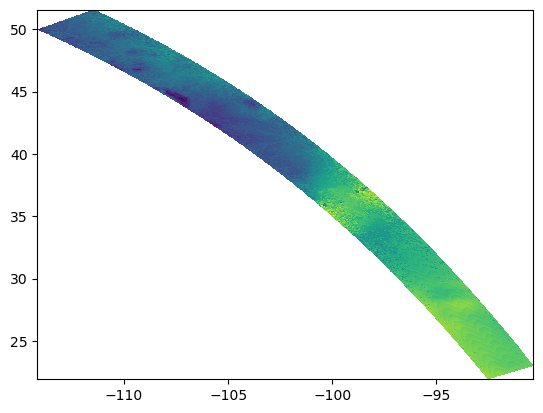

In [95]:
plt.pcolormesh(lon,lat,wvp)

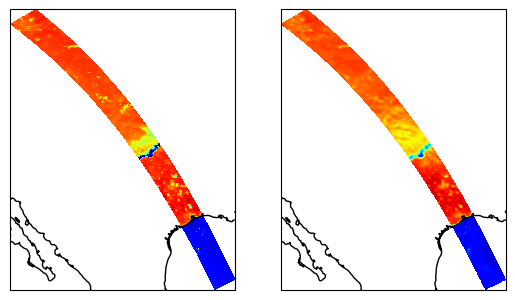

In [68]:
ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
ax.coastlines()
plt.pcolormesh(lon,lat,tb_sim[:,:,6],transform=ccrs.PlateCarree(),cmap='jet',vmin=160,vmax=300)
#plt.colorbar()
ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
ax.coastlines()
plt.pcolormesh(lon,lat,tb_s1_resampled[:,:,6],transform=ccrs.PlateCarree(),cmap='jet',vmin=160,vmax=300)
#plt.colorbar()


In [8]:
print(kext.shape)

(8, 78)


In [66]:
import netCDF4 as nc
with nc.Dataset('Data/2A-ENV.GPM.DPR.V9-20211125.20180625-S041042-E054316.024557.V07A.HDF5') as f:
    qv_env=f['FS/VERENV/waterVapor'][4500:5500,:,:]
    press_env=f['FS/VERENV/airPressure'][4500:5500,:,:]
    lon_env=f['FS/Longitude'][4500:5500,:]
    lat_env=f['FS/Latitude'][4500:5500,:]

print(qv.shape)

(744, 49, 10)


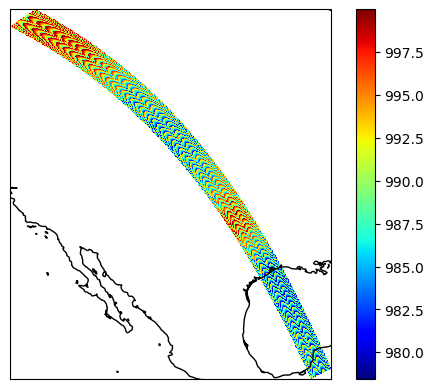

In [67]:
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
plt.pcolormesh(lon_env,lat_env,press_env[:,:,-1],cmap='jet')

ax.coastlines()
plt.colorbar()